# What is my old car worth?

Following the extension of the family, we decided to buy a new, bigger, car, and hence to sell our old car (an Audi A3 sportsback). There exists online ressources to evaluate the price of used cars on the market (Eurotax for the swiss market) which I most probably use to fix a price (since that's the reference buyers watch), but I thought it was an interesting data science case to evaluate the price of my car based on the market, using web scraping and a bit of machine learning.

The adopted strategy consists into 3 steps:
- first acquire some data online including the price and the car characteristics
- build a pricing model using machine learning
- evaluate the price of my car given its characteristics

In addition, it will be interesting to see if Eurotax and the market agree with each other. My guess is that the market should be close to but slightly more expensive than Eurotax, because people tend to overestimate the price of their goods when selling them.

## Preamble

As usual we import the necessary libraries.

In [8]:
# system libraries
import os
import sys
import re
from datetime import date, datetime, timedelta
import numpy as np

# for data handling
import pandas as pd

# for web scraping
import requests
from bs4 import BeautifulSoup

# for plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
plt.rc('pdf',fonttype=42)

import seaborn as sns
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context(
    'notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})

## Data acquisition

To obtain the data I need, I get the data from a swiss selling items web site, focusing on the used car ads. I had several choices but I found one site that was relatively easy to analyse while having many ads (about 200k used car ads).

As usual the goal is to find the best compromise between getting as much data as possible while saving ressources in time and computing power (from both sides of the server and the client). The approach I choose is to get the data from the ad preview, which already contains the most critical pieces of information (such as car model, price, age and kilometers).

In [66]:
# see ad web site scraping

## Data exploration

The scraping has been done twice. The first time on June 22nd and one week later. The goal is to see which typical ads have disappeared in the interval (i.e. if they were sold rapidely).

### Import data

In [3]:
data_dir = 'data'

In [62]:
# read csv files
df_1 = pd.read_csv(data_dir+'/22.06.2019_all.csv', index_col='item_id')
df_2 = pd.read_csv(data_dir+'/29.06.2019_all.csv', index_col='item_id')

# merge the two
df_ads = df_1.join(
    df_2['age_ad_days'], rsuffix='_2', how='left', on='item_id')

# create a new column: True if it disa
select = (df_ads['age_ad_days_2'].isnull()) & (df_ads['date']>='2019-06-21')
df_ads['less_than_a_week'] = select
df_ads = df_ads.drop('age_ad_days_2', axis=1)

# Display numbers
print('Total: {0}. Disappeared in 1 week: {1}'.format(len(df_ads), sum(select)))

Total: 232642. Disappeared in 1 week: 1176


In [157]:
df_ads.drop('link', axis=1).head()

,date,description,engine,km,location,name,price,year,brand,model,model details,age_car_years,age_ad_days,less_than_a_week
item_id,,,,,,,,,,,,,,
29510324,2019-06-17,\n*FAHRZEUG IN GUTEN ZUSTAND* *SERVICE GEPFLEG...,Diesel,176000.0,Wetzikon,AUDI A6 Avant 2.7 V6 TDI,5500.0,2008-01-01,AUDI,A6,Avant,11.501370,13.0,False
29510323,2019-06-17,\nAusstattung:AlufelgenManuelle KlimaanlageEin...,Essence,78300.0,Ringgenberg,BMW X1 xDrive 20i Steptronic,19800.0,2014-01-01,BMW,X1,xDrive,5.495890,13.0,False
29510305,2019-06-17,\nA vendre belle BMW 325xi en excellent état.L...,Essence,134000.0,L'Auberson,"BMW 325xi, 2007, 134'000 km",10000.0,2007-01-01,BMW,"325xi,","2007,",12.501370,13.0,False
29510302,2019-06-17,"\nHonda civic 1,4 90 cvUne portière est légére...",Essence,205000.0,Dombresson,"Honda civic, 2000, 205'000 km",1200.0,2000-01-01,Honda,"civic,","2000,",19.506849,13.0,False
29510298,2019-06-17,\nBesichtigung und Probefahrt jeder Zwit mögli...,Essence,197490.0,Grub AR,"Ford Fiesta, 2008, 197'490 km",2900.0,2008-01-01,Ford,"Fiesta,","2008,",11.501370,13.0,False


### Cleaning

We take a quick look at the data and clean what's necessary. Here we see that a number of ads are over 1000 days old and some have no valid date. This may correspond to promoted ads. We remove them. We also remove prices over CHF 1M. 

Identically, some ads have a very high number of kilometers.

In total we get rid of 36% of ads.

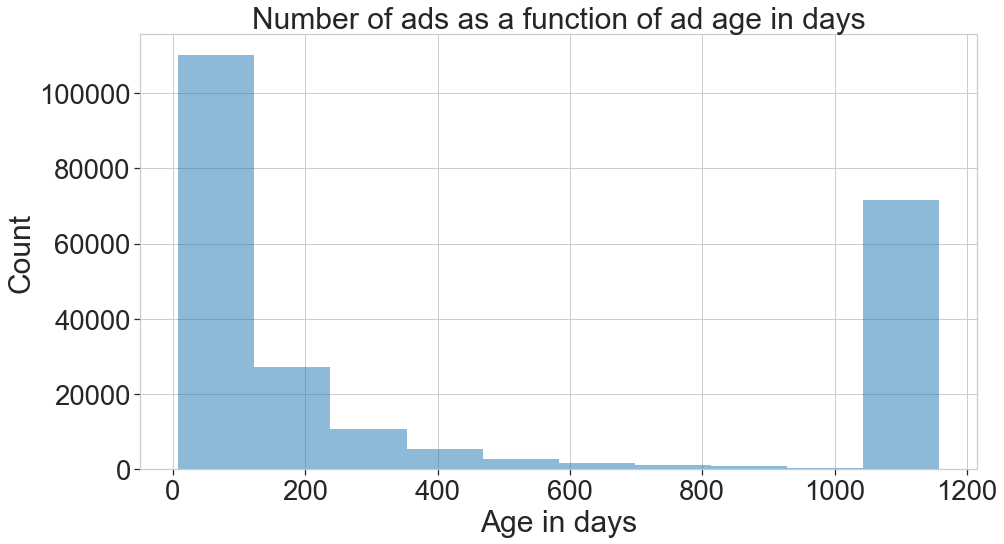

In [109]:
fig, ax = plt.subplots(figsize=(15,8))

ax.hist(
    df_ads['age_ad_days'].dropna(), alpha=0.5, 
    label='All', density=False) #, bins=np.linspace(10,50))
ax.set_xlabel('Age in days')
ax.set_ylabel('Count')
ax.set_title('Number of ads as a function of ad age in days')

None

In [64]:
# cleaning
select = df_ads['age_ad_days'] > 0
select &= df_ads['age_ad_days'] < 1000
select &= df_ads['price'] < 1.e6
select &= df_ads['price'] > 0
select &= df_ads['km'] > 0
select &= df_ads['km'] < 2.e5
df_ads_clean = df_ads[select]

# how much is it dropped?
N = len(df_ads)
N_clean = len(df_ads_clean)

#(len(df_ads)-len(df_ads_clean))/len(df_ads)

print('N: {}, N(clean): {} , dropped fraction: {:.2f}%'.format(
    N, N_clean, 100.*(N-N_clean)/N))

N: 232642, N(clean): 149590 , dropped fraction: 35.70%


In [67]:
df_ads_clean.drop('link', axis=1).head()

,date,description,engine,km,location,name,price,year,brand,model,model details,age_car_years,age_ad_days,less_than_a_week
item_id,,,,,,,,,,,,,,
29510324,2019-06-17,\n*FAHRZEUG IN GUTEN ZUSTAND* *SERVICE GEPFLEG...,Diesel,176000.0,Wetzikon,AUDI A6 Avant 2.7 V6 TDI,5500.0,2008-01-01,AUDI,A6,Avant,11.501370,13.0,False
29510323,2019-06-17,\nAusstattung:AlufelgenManuelle KlimaanlageEin...,Essence,78300.0,Ringgenberg,BMW X1 xDrive 20i Steptronic,19800.0,2014-01-01,BMW,X1,xDrive,5.495890,13.0,False
29510305,2019-06-17,\nA vendre belle BMW 325xi en excellent état.L...,Essence,134000.0,L'Auberson,"BMW 325xi, 2007, 134'000 km",10000.0,2007-01-01,BMW,"325xi,","2007,",12.501370,13.0,False
29510298,2019-06-17,\nBesichtigung und Probefahrt jeder Zwit mögli...,Essence,197490.0,Grub AR,"Ford Fiesta, 2008, 197'490 km",2900.0,2008-01-01,Ford,"Fiesta,","2008,",11.501370,13.0,False
29510297,2019-06-17,\nFerrari Mondial F 108 AL/Quattrovalvole – 19...,Essence,92200.0,Genève,"Ferrari Mondial, 1983, 92'200 km",39500.0,1983-01-01,Ferrari,"Mondial,","1983,",36.517808,13.0,False


## Price distribution

The price is our target to estimate. We take a look at its distribtution. Interstingly, the price distribution is roughly log-normal, i.e. the logarithm of it normal, and hence skewed towards higher values. The median price is CHF 28'800.

We overplot the distribution of ads that disappeared within 1 week in red, "first off" the list. We see a significant decrease in price. The median price is CHF 8000. This is consistent with the fact that cheaper cars are sold faster.

24800.0 8000.0


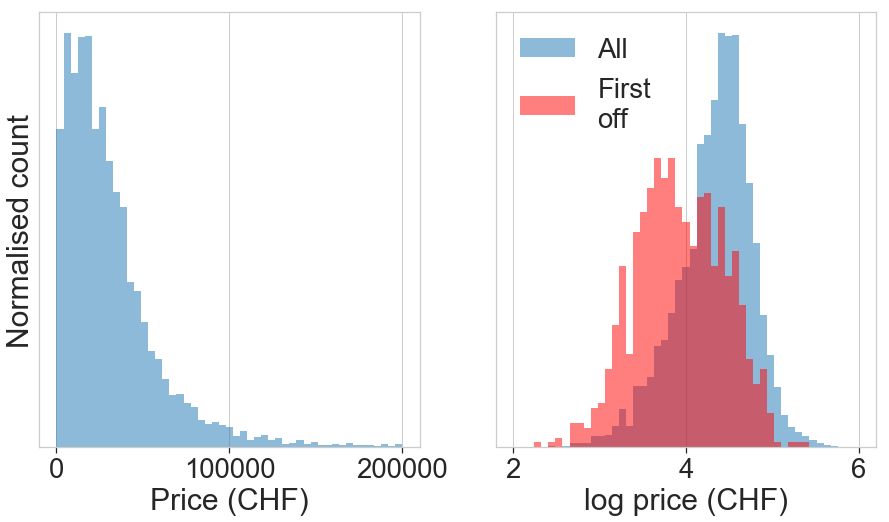

In [110]:
fig, ax = plt.subplots(1,2, figsize=(15,8), sharey=False)

ax[0].hist(
    df_ads_clean['price'], alpha=0.5,
    label='All', density=True, bins=np.linspace(0,2.e5))
ax[0].set_xlabel('Price (CHF)')

ax[1].hist(
    np.log10(df_ads_clean['price']),density=True, alpha=0.5, 
    label='All', bins=np.linspace(2,6))

select = df_ads_clean['less_than_a_week']
ax[1].hist(
    np.log10(df_ads_clean[select]['price']), alpha=0.5, 
    label='First\noff', density=True, bins=np.linspace(2,6), color='red')

ax[1].set_xlabel('log price (CHF)')

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].set_ylabel('Normalised count')

ax[1].legend()

print(df_ads_clean['price'].median(), df_ads_clean[select]['price'].median())

None

## Features

Next, we explore here the distribution of features and the correlation between them. First we pick a number of features and see how the price depends on them, then we look at the distribution of the features. 

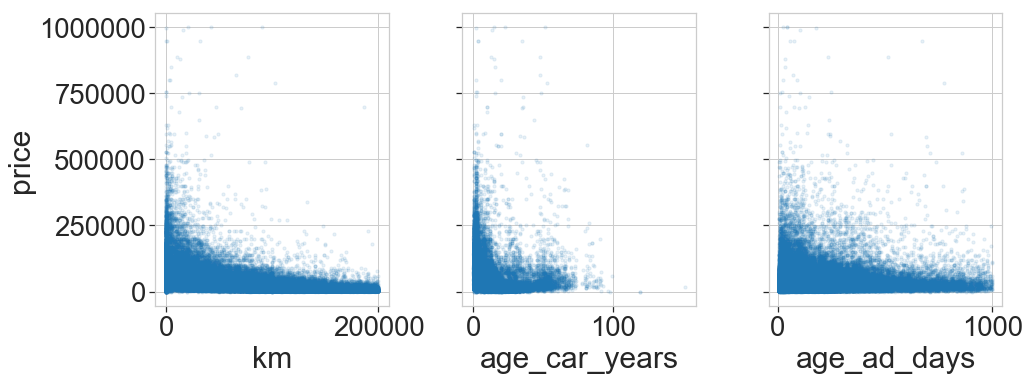

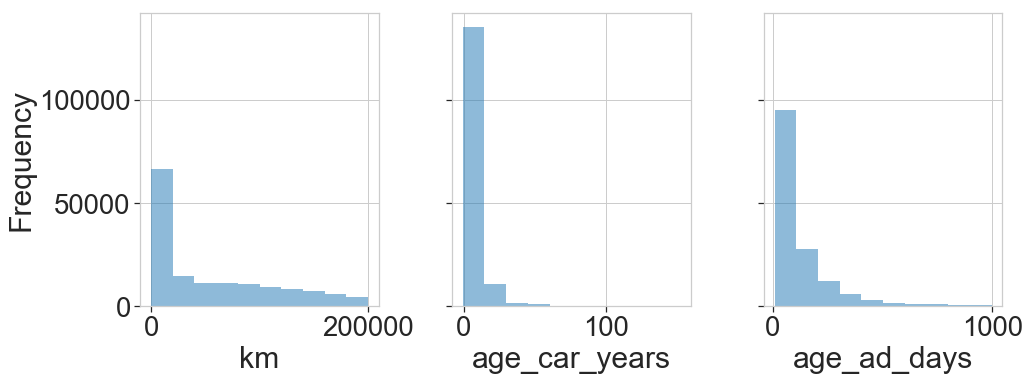

In [13]:
attributes = ['km', 'age_car_years',  'age_ad_days']
# fig, ax = plt.subplots(figsize=(4,4))
n_i, n_j = 1, 3
fig, ax = plt.subplots(
    n_i, n_j, figsize=(15, 6), sharey = True)
# plot price vs attribute
for k, a in enumerate(attributes):
    df_ads_clean.plot.scatter(
        x=a, y='price',
        ax=ax[k], 
        s=10, alpha=0.1)
fig.tight_layout()

fig, ax = plt.subplots(
    n_i, n_j, figsize=(15, 6), sharey = True)
    
# plot price vs attribute
for k, a in enumerate(attributes):
    df_ads_clean[a].plot.hist(
        ax=ax[k], alpha=0.5, logy=False)
    ax[k].set_xlabel(a)

fig.tight_layout()

# ax=ax[k%n_i, k//n_i],
# do not plot axes with no data
#for k in range(len(attributes),n_i*n_j ):
#    ax[k%n_i, k//n_i].axis('off')


None

Most cars have few kilometers and are relatively new. As expected the price increases with low km and small age. 

## Price modelling

We will now focus on a specific model, i.e. the one we attempt to model the price, an Audi A3.

### Selection of the car model

We apply a number of filters on the brand, model and model details. As the text form is free, we are flexible in the search term. 

In [55]:
# Brand and model
select = df_ads_clean['brand'].fillna('').str.contains('Audi|AUDI|audi')
select &= df_ads_clean['model'].fillna('').str.contains('A3|a3')

# Select specifically the sportsback (5 doors) models
select &= \
    df_ads_clean['model details'].fillna('').str.contains('Sportback|sportback')\
    |df_ads_clean['description'].fillna('').str.contains('Sportback|sportback')\
    |df_ads_clean['name'].fillna('').str.contains('Sportback|sportback')

# Engine type
select &= \
    df_ads_clean['model details'].fillna('').str.contains('TDI')\
    |df_ads_clean['description'].fillna('').str.contains('TDI')\
    |df_ads_clean['name'].fillna('').str.contains('TDI')

# We exclude new cars
select &= df_ads_clean['km'] > 1000.
select &= df_ads_clean['age_car_years'] > 1

df_Audi_A3 = df_ads_clean[select].copy()

print(sum(select))

247


### feature selection

We now plot the price as a function of km and age of the car for the Audi A3. We observe the same trends as before, i.e. that the price increases with decreasing km and age, but much clearly than with the full population (See above).

We then split the sample in two, above and below the median ad age (50 days). The former is plotted in blue ("newest") whereas the latter is plotted in red ("oldest"). WHerease no significant trend is visible a priori on the plot, when we look at the *mean* price, however, oldest ads have a higher value, and both the ratio mean(price)/mean(age) and the ratio mean(price)/mean(km) are higher (around 30%) for old ads than new ads.

The two features km and car age will be our machine learning primary parameters to model the price. Since the price is an exponentially decreasing function of both parameters, it's clear that some transformation will ease the modelling (see next section).

Median age of the ad in days 58.0
Newest:
 km                   97928.564516
price                16873.500000
age_car_years            6.537251
age_ad_days             29.209677
less_than_a_week         0.000000
log_age_car_years        0.747052
log_km                   4.924243
dtype: float64
Oldest:
 km                   86942.609756
price                19864.528455
age_car_years            6.073728
age_ad_days            172.414634
less_than_a_week         0.000000
log_age_car_years        0.696783
log_km                   4.789348
dtype: float64
Price to age ratio newest: 2581.13
Price to age ratio oldest: 3270.57
Price to km ratio newest: 0.17
Price to km ratio oldest: 0.23
Price to km and age ratio newest: 0.026
Price to km and age ratio oldest: 0.038


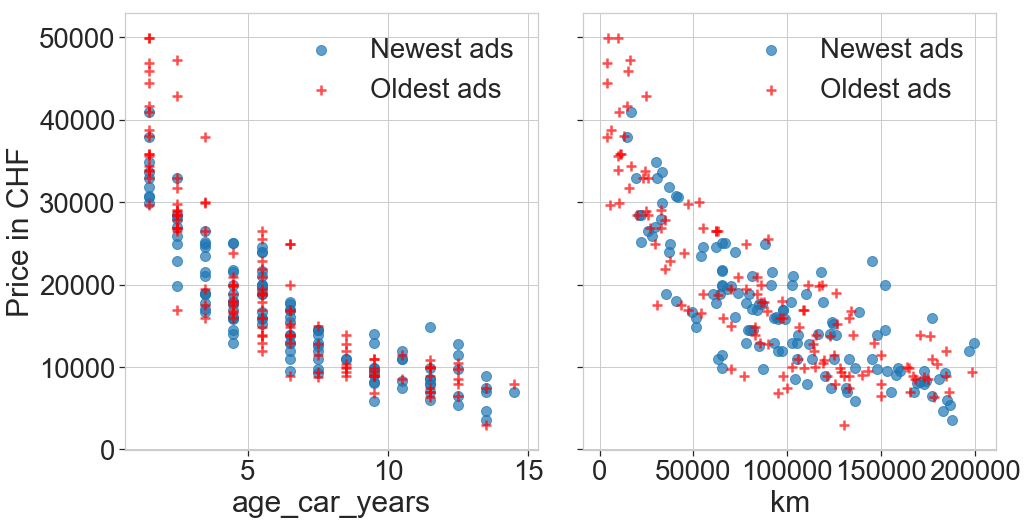

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharey=True)

select = df_Audi_A3['age_ad_days'] > df_Audi_A3['age_ad_days'].median()

df_Audi_A3[~select].plot.scatter(
    marker='o', x='age_car_years', 
    y='price', ax=ax[0], s=100, alpha=0.7, label='Newest ads')
df_Audi_A3[~select].plot.scatter(
    marker='o', x='km',
    y='price', ax=ax[1], s=100, alpha=0.7, label='Newest ads ')

print('Median age of the ad in days', df_Audi_A3['age_ad_days'].median())

means_newest = df_Audi_A3[~select].mean()
means_oldest = df_Audi_A3[select].mean()

print('Newest:\n', means_newest)
print('Oldest:\n', means_oldest)

print('Price to age ratio newest: {:.2f}'.format(means_newest['price']/means_newest['age_car_years']))
print('Price to age ratio oldest: {:.2f}'.format(means_oldest['price']/means_oldest['age_car_years']))

print('Price to km ratio newest: {:.2f}'.format(means_newest['price']/means_newest['km']))
print('Price to km ratio oldest: {:.2f}'.format(means_oldest['price']/means_oldest['km']))

# print('Price to km and age ratio newest: {:.3f}'.format(means_newest['price']/means_newest['km']/means_newest['age_car_years']))
# print('Price to km and age ratio oldest: {:.3f}'.format(means_oldest['price']/means_oldest['km']/means_oldest['age_car_years']))

if select.any():
    df_Audi_A3[select].plot.scatter(
        x='age_car_years', y='price', ax=ax[0], s=100, alpha=0.7,
        marker='+', c='red', label='Oldest ads')
    df_Audi_A3[select].plot.scatter(
        x='km', y='price', ax=ax[1], s=100, alpha=0.7,
        marker='+', c='red', label='Oldest ads')

select = df_Audi_A3['less_than_a_week']
if select.any():
    df_Audi_A3[select].plot.scatter(
        x='age_car_years', y='price', ax=ax[0], s=100, alpha=0.7,
        marker='o', c='green', label='Sold in < 1 week')
    df_Audi_A3[select].plot.scatter(
        x='km', y='price', ax=ax[1], s=100, alpha=0.7,
        marker='o', c='green', label='Sold in < 1 week')

# Aestetics
ax[0].set_ylabel('Price in CHF')

fig.tight_layout()

We also plot the km as a function of car age. As expected the former increases with the latter. What's interesting is to see the high scatter for high values, and that's what interests us given that our car is old but with relatively few km, so we will see to model it properly to see whether it increases its value. 

And to start analysing we set the point color as the price. We clearly see the strong dependence on age. However, the km dependence seems to be less promominent. We will probably find that the age is the primary factor to estimate the price.

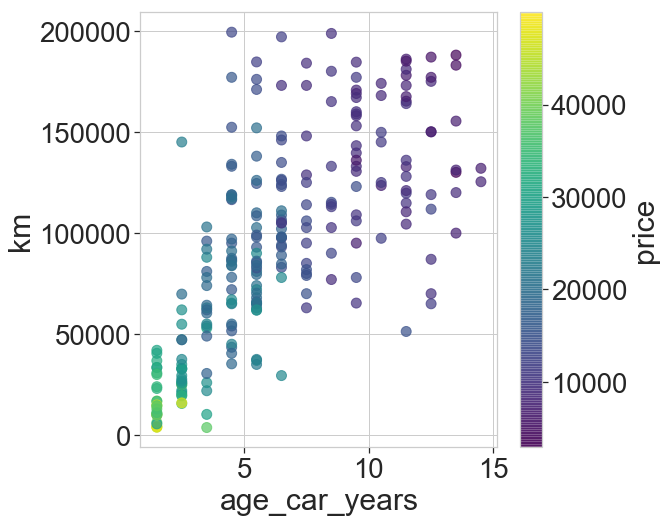

In [142]:
fig, ax = plt.subplots(figsize=(8,8))

df_Audi_A3.plot.scatter(
    marker='o', x='age_car_years', y='km', 
    ax=ax, s=100, alpha=0.7, c='price', cmap='viridis')

None

## Feature transformation

Since the price is an exponentially decreasing function of age and km, we apply a logarithmic transformation of the features (a particular case of cox-box transformation):

In [130]:
df_Audi_A3['log_age_car_years'] = df_Audi_A3['age_car_years'].apply(np.log10)
df_Audi_A3['log_km'] = df_Audi_A3['km'].apply(np.log10)

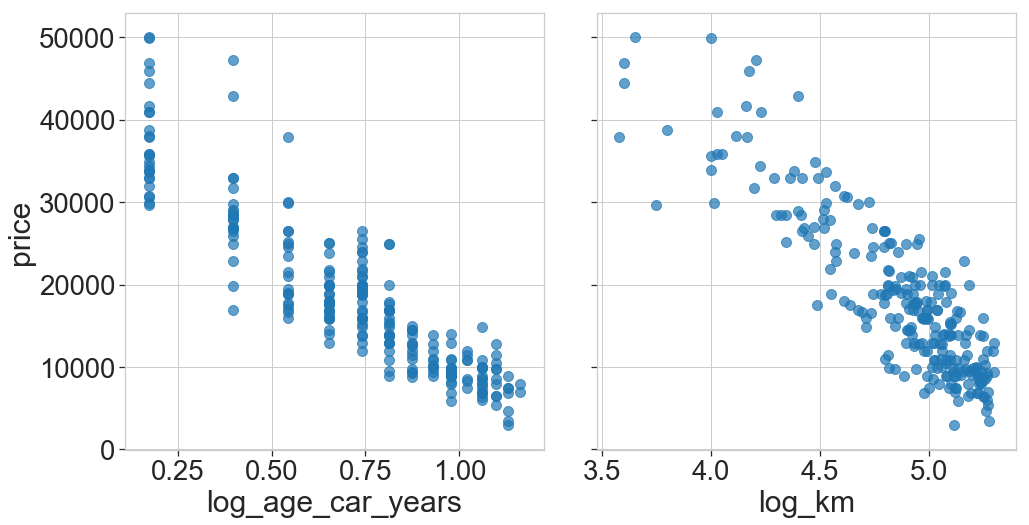

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharey=True)

df_Audi_A3.plot.scatter(
    marker='o', x='log_age_car_years', y='price', ax=ax[0], s=100, alpha=0.7)
df_Audi_A3.plot.scatter(
    marker='o', x='log_km', y='price', ax=ax[1], s=100, alpha=0.7)

fig.tight_layout()

## Price modeling

We finally apply a machine learning algorithm to model and predict the price. We test a linear, a random forest, and a support Vector machine (SVN) models. To test the model, we compute a mean square error (root squared) and the score provided by the model object (r$^2$ score in the linear case) on a "test" sample kept aside when training the model.

In [144]:
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import metrics

In [133]:
# functions
def split_data(X, y):
    """ Split the data assuming 
    training: 80%, test: 20% """
    
    X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(
        X, y, test_size=0.20)

    return X_train, X_test, y_train, y_test

def fit_data(df, model, n_iter=100):
  
    # perform multiple regression
    attributes = ['log_age_car_years', 'log_km']

    X = df[attributes]
    y = df['price']

    error = np.zeros(n_iter)
    score = np.zeros(n_iter)
    for n in range(n_iter):
        X_train, X_test, y_train, y_test = split_data(X, y)

        model.fit(X_train, y_train)

        y_test_predict = model.predict(X_test)
        y_train_predict = model.predict(X_train)

        error[n] = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
        score[n] = model.score(X_test, y_test)
    
    
    return error.mean(), error.std(), score.mean(), score.std()


In [141]:
# Test several models
models ={
    'Linear': LinearRegression(normalize=True, fit_intercept=True),
    'Random Forest': RandomForestRegressor(n_estimators=20),
#    'Neural network': MLPRegressor(hidden_layer_sizes=(10,)),
    'SVM': svm.SVC(gamma='scale'),
}

for model_name in models.keys():
    error, error_std, score, score_std = fit_data(df_Audi_A3, models[model_name])
    
    error_str = 'error: {:.2f} (+/- {:.2f})'.format(error, error_std)
    score_str = ', score: {:.2f} (+/- {:.2f})'.format(score, score_std)
    print('{:20}'.format(model_name)+error_str,score_str)


SVM                 error: 11033.94 (+/- 1827.52) , score: 0.01 (+/- 0.02)
Linear              error: 3160.86 (+/- 499.76) , score: 0.88 (+/- 0.03)
Random Forest       error: 3773.83 (+/- 499.99) , score: 0.84 (+/- 0.04)


The linear model performs best. The random forest is also quite good whereas the SVM model is significantly worse than the other 2.

## Audi price

In this final step, we predict the price of our Audi, given that it's 13 years old and has 96'000 km. 

We have seen previously that the model predictions were relatively noisy even for one model. Since the training process is fast, we randomise the process to evaluate the typical price variation due to the machine learning process. To do so, we repeat the training and prediction 100 times, then computing the mean and standard deviation of the price.

For the linear model, the predicted price from the market is CHF 9300 (+/- 170).



In [135]:
def estimate_price(df, model, n_iter=100):
  
    # perform multiple regression
    attributes = ['log_age_car_years', 'log_km']

    X = df[attributes]
    y = df['price']

    log_x = np.log10([13.0, 96000.])

    price = np.zeros(n_iter)
    for n in range(n_iter):
        X_train, X_test, y_train, y_test = split_data(X, y)
        model.fit(X_train, y_train)

        price[n] = model.predict([log_x])
    
    return price.mean(), price.std()


In [140]:
for model_name in models.keys():
    price, price_std = estimate_price(df_Audi_A3, models[model_name])
    
    price_str = 'price: {:.2f} (+/- {:.2f})'.format(price, price_std)
    print('{:20}'.format(model_name)+price_str)

SVM                 price: 11400.00 (+/- 2282.54)
Linear              price: 9293.64 (+/- 161.00)
Random Forest       price: 8270.22 (+/- 569.89)


Finally estimate using oldest and newest ads as training. The linear model is similar. The svm and random forest feature significant higher prices when trained with oldest ads.

In [155]:
newest = df_Audi_A3['age_ad_days'] > df_Audi_A3['age_ad_days'].median()
oldest = df_Audi_A3['age_ad_days'] <= df_Audi_A3['age_ad_days'].median()

for model_name in models.keys():
    price, price_std = estimate_price(df_Audi_A3[newest], models[model_name])
    
    price_str = 'price: {:.2f} (+/- {:.2f})'.format(price, price_std)
    print('{:20}'.format(model_name)+price_str)
    
for model_name in models.keys():
    price, price_std = estimate_price(df_Audi_A3[oldest], models[model_name])
    
    price_str = 'price: {:.2f} (+/- {:.2f})'.format(price, price_std)
    print('{:20}'.format(model_name)+price_str)

SVM                 price: 9050.00 (+/- 852.94)
Linear              price: 9167.52 (+/- 268.07)
Random Forest       price: 7397.53 (+/- 798.93)
SVM                 price: 12332.00 (+/- 1382.96)
Linear              price: 9142.81 (+/- 200.73)
Random Forest       price: 10292.62 (+/- 705.35)


In [36]:
# log_x = np.log10([13.0, 96000.])
# models['Linear'].predict([log_x])

## Feature importance

A final interesting thing to do is explore the importance of features, which can be done with random forest. Since part of randomisation process is done on the feature, the algorithm is able to estimate which feature gives the most information.  

Here we see that the age is the most important feature, contributing to almost 70% of the fitting process, whereas the number of km only contribute to only 30%.

In [143]:
attributes = ['log_age_car_years', 'log_km']

importances = models['Random Forest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in models['Random Forest'].estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

X = df_Audi_A3[attributes]
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), X.columns[f])

Feature ranking:
1. feature 1 (0.601416) log_age_car_years
2. feature 0 (0.398584) log_km


## Conclusion

- choice of model: linear
- best estimation: 9300
- most import feature: age of the car
- oldest ads have a higher price 